>20, 117/390, d1=0.704, d2=0.665 g=0.857
 >Accuracy real: 40%, fake: 79%
>20, 118/390, d1=0.701, d2=0.647 g=0.883
 >Accuracy real: 43%, fake: 81%
>20, 119/390, d1=0.702, d2=0.607 g=0.905
 >Accuracy real: 33%, fake: 84%
>20, 120/390, d1=0.747, d2=0.624 g=0.944
 >Accuracy real: 37%, fake: 93%
>20, 121/390, d1=0.744, d2=0.523 g=0.932
 >Accuracy real: 37%, fake: 92%
>20, 122/390, d1=0.706, d2=0.572 g=0.867
 >Accuracy real: 50%, fake: 79%
>20, 123/390, d1=0.683, d2=0.679 g=0.870
 >Accuracy real: 44%, fake: 80%
>20, 124/390, d1=0.747, d2=0.615 g=0.834
 >Accuracy real: 51%, fake: 84%
>20, 125/390, d1=0.720, d2=0.649 g=0.778
 >Accuracy real: 51%, fake: 81%
>20, 126/390, d1=0.632, d2=0.660 g=0.803
 >Accuracy real: 55%, fake: 77%
>20, 127/390, d1=0.601, d2=0.673 g=0.817
 >Accuracy real: 53%, fake: 76%
>20, 128/390, d1=0.673, d2=0.669 g=0.818
 >Accuracy real: 50%, fake: 79%
>20, 129/390, d1=0.637, d2=0.717 g=0.832
 >Accuracy real: 59%, fake: 81%
>20, 130/390, d1=0.671, d2=0.644 g=0.852
 >Accuracy

KeyboardInterrupt: ignored

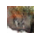

In [1]:
# example of a dcgan on cifar10
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.cifar10 import load_data
from keras.optimizers import Adam
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from matplotlib import pyplot
# define the discriminator model
def define_discriminator(in_shape=(32,32,3)):
  model = Sequential()
# normal
  model.add(Conv2D(64, (3,3), padding= "same", input_shape=in_shape))
  model.add(LeakyReLU(alpha=0.2))
# downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding= "same" ))
  model.add(LeakyReLU(alpha=0.2))
# downsample
  model.add(Conv2D(128, (3,3), strides=(2,2), padding= "same" ))
  model.add(LeakyReLU(alpha=0.2))
# downsample
  model.add(Conv2D(256, (3,3), strides=(2,2), padding= "same" ))
  model.add(LeakyReLU(alpha=0.2))
# classifier
  model.add(Flatten())
  model.add(Dropout(0.4))
  model.add(Dense(1, activation="sigmoid"))
# compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss= "binary_crossentropy" , optimizer=opt, metrics=[ "accuracy" ])
  return model

# define the generator model
def define_generator(latent_dim):
  model = Sequential()
# foundation for 4x4 image
  n_nodes = 256 * 4 * 4
  model.add(Dense(n_nodes, input_dim=latent_dim))
  model.add(LeakyReLU(alpha=0.2))
  model.add(Reshape((4, 4, 256)))
# upsample to 8x8
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding= "same"))
  model.add(LeakyReLU(alpha=0.2))
# upsample to 16x16
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding= "same"))
  model.add(LeakyReLU(alpha=0.2))
# upsample to 32x32
  model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding= "same"))
  model.add(LeakyReLU(alpha=0.2))
# output layer
  model.add(Conv2D(3, (3,3), activation= "tanh", padding= "same"))
  return model

# define the combined generator and discriminator model, for updating the generator via discriminator
def define_gan(g_model, d_model):

  d_model.trainable = False
# connect them
  model = Sequential()
# add generator
  model.add(g_model)
# add the discriminator
  model.add(d_model)
# compile model
  opt = Adam(lr=0.0002, beta_1=0.5)
  model.compile(loss= "binary_crossentropy" , optimizer=opt)
  return model

# load and prepare cifar10 training images
def load_real_samples():
  # load cifar10 dataset
  (trainX, _), (_, _) = load_data()
# convert from unsigned ints to floats
  X = trainX.astype("float32" )
# scale from [0,255] to [-1,1]
  X = (X - 127.5) / 127.5
  return X
# select real samples
def generate_real_samples(dataset, n_samples):
# choose random instances
  ix = randint(0, dataset.shape[0], n_samples)
# retrieve selected images
  X = dataset[ix]
# generate ✬ real ✬ class labels (1)
  y = ones((n_samples, 1))
  return X, y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
# generate points in the latent space
  x_input = randn(latent_dim * n_samples)
# reshape into a batch of inputs for the network
  
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
# generate points in latent space
  x_input = generate_latent_points(latent_dim, n_samples)
# predict outputs
  X = g_model.predict(x_input)
# create ✬ fake ✬ class labels (0)
  y = zeros((n_samples, 1))
  return X, y
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
# scale from [-1,1] to [0,1]
  examples = (examples + 1) / 2.0
# plot images
  for i in range(n * n):

# define subplot
    pyplot.subplot(n, n, 1 + i)
# turn off axis
    pyplot.axis("off" )
# plot raw pixel data
    pyplot.imshow(examples[i])
# save plot to file
    filename = "generated_plot_e%03d.png"% (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
# prepare real samples
  X_real, y_real = generate_real_samples(dataset, n_samples)
# evaluate discriminator on real examples
  _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)
# prepare fake examples
  x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)
# evaluate discriminator on fake examples
  _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)
# summarize discriminator performance
  print( " >Accuracy real: %.0f%%, fake: %.0f%%"% (acc_real*100, acc_fake*100))
# save plot
  save_plot(x_fake, epoch)
# save the generator model tile file
  filename = "generator_model_%03d.h5"% (epoch+1)
  g_model.save(filename)
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=128):
  bat_per_epo = int(dataset.shape[0] / n_batch)
  half_batch = int(n_batch / 2)
# manually enumerate epochs
  for i in range(n_epochs):

# enumerate batches over the training set
   for j in range(bat_per_epo):

 
# get randomly selected ✬ real ✬ samples
    X_real, y_real = generate_real_samples(dataset, half_batch)
# update discriminator model weights
    d_loss1, _ = d_model.train_on_batch(X_real, y_real)
# generate ✬ fake ✬ examples
    X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
# update discriminator model weights
    d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
# prepare points in latent space as input for the generator
    X_gan = generate_latent_points(latent_dim, n_batch)
# create inverted labels for the fake samples
    y_gan = ones((n_batch, 1))
# update the generator via the discriminator ✬ s error
    g_loss = gan_model.train_on_batch(X_gan, y_gan)
# summarize loss on this batch
    print( ">%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f" %
    (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
# evaluate the model performance, sometimes
    if (i+1) % 10 == 0:
      summarize_performance(i, g_model, d_model, dataset, latent_dim)
    
# size of the latent space
latent_dim =100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

/usr/local/lib/python3.6/dist-packages/keras/engine/saving.py:341: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


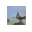

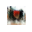

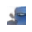

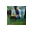

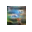

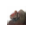

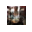

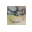

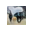

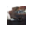

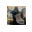

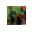

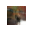

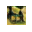

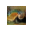

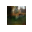

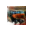

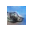

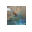

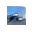

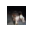

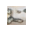

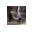

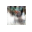

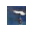

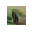

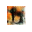

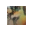

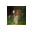

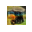

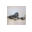

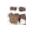

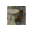

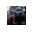

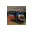

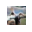

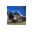

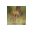

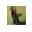

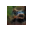

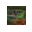

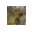

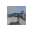

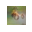

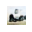

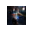

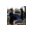

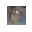

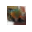

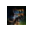

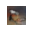

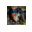

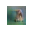

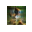

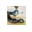

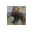

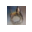

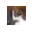

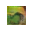

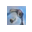

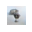

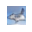

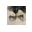

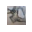

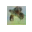

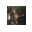

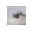

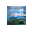

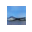

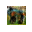

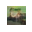

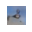

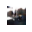

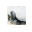

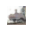

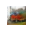

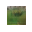

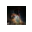

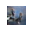

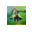

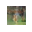

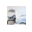

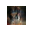

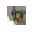

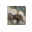

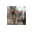

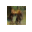

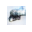

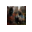

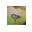

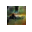

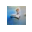

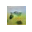

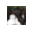

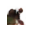

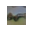

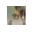

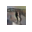

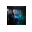

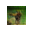

In [5]:
#I interupted training due to ram shortage but still getting good generated images as you can see below
# example of loading the generator model and generating images
from keras.models import load_model
from numpy.random import randn
from matplotlib import pyplot
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
# generate points in the latent space
  x_input = randn(latent_dim * n_samples)
# reshape into a batch of inputs for the network
  x_input = x_input.reshape(n_samples, latent_dim)
  return x_input
# create and save a plot of generated images
def save_plot(examples, n):
# plot images
  for i in range(n * n):

# define subplot
   pyplot.subplot(n, n, 1 + i)
# turn off axis
   pyplot.axis( "off" )
# plot raw pixel data
   pyplot.imshow(examples[i, :, :])
   pyplot.show()
# load model
model = load_model( "/content/generator_model_020.h5" )
# generate images
latent_points = generate_latent_points(100, 100)
# generate images
X = model.predict(latent_points)
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)  
